# Get started with EMR Serverless on EMR Studio

#### Topics covered in this example
<ol>
    <li> Configure a Spark session </li>
    <li> Import a library to help with plot </li>
    <li> Spark DataFrames: reading a public dataset, selecting data and writing to a S3 location </li>
    <li> Spark SQL: creating a new view and selecting data </li>
    <li> Visualize your data </li>
</ol>

***

## Prerequisites
<div class="alert alert-block alert-info">
<b>NOTE :</b> In order to execute this notebook successfully as is, please ensure the following prerequisites are completed.</div>

* EMR Serverless should be chosen as the Compute.
* Make sure the Studio user role has permission to attach the Workspace to the Application and to pass the runtime role to it.
* This notebook uses the `PySpark` kernel.
* Your Serverless Application must be configured with a VPC that has internet connectivity. [Learn more](https://docs.aws.amazon.com/emr/latest/EMR-Serverless-UserGuide/vpc-access.html)
***

## 1. Configure your Spark session.
First we specify an execution role. Make sure you replace the <<account-id>> in the cell below. If you have a different name for your role, replace the role ARN as applicable.
Configure the Spark Session to use Virtualenv. Virtualenv is needed to install other Python packages.

In [1]:
%%configure -f
{
  "conf": {
    "emr-serverless.session.executionRoleArn": "arn:aws:iam::<<acount-id>>:role/livyendpointemr",
    "spark.pyspark.virtualenv.enabled": "true",
    "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv",
    "spark.pyspark.virtualenv.type": "native",
    "spark.pyspark.python": "/usr/bin/python3",
    "spark.executorEnv.PYSPARK_PYTHON": "/usr/bin/python3"
  }
}



Start a Spark session:

In [2]:
spark

VBox()

Starting Spark application


ID,Kind,State,Spark UI,Driver log,User,Current session?
0,pyspark,idle,Link,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Run the `%%info` magic command which shows the Spark configuration for the current session as well as provides links to navigate to the live Spark UI for the session:

In [3]:
%%info

ID,Kind,State,Spark UI,Driver log,User,Current session?
0,pyspark,idle,Link,,None,✔


---
## 2. Install packages from PyPI
We will install matplotlib Python package. 
<div class="alert alert-block alert-info">
<b>NOTE :</b> You will need internet access to do this step.</div>

In [4]:
sc.install_pypi_package("matplotlib")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---
## 3. Read data from S3
We will use a public data set on NYC yellow taxis. Read the Parquet file from S3. The file has headers and we want Spark to infer the schema. 
<div class="alert alert-block alert-info">
<b>NOTE :</b> You will need to update your runtime role to allow Get access to the s3://athena-examples-us-east-1/notebooks/ folder and its sub-folders.</div>

In [5]:
file_name = "s3://athena-examples-us-east-1/notebooks/yellow_tripdata_2016-01.parquet"

taxi_df = (spark.read.format("parquet").option("header", "true") \
           .option("inferSchema", "true").load(file_name))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Use Spark Dataframe to group and count specific column from taxi_df

In [5]:
taxi1_df = taxi_df.groupBy("VendorID", "passenger_count").count()
taxi1_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------------+-------+
|VendorID|passenger_count|  count|
+--------+---------------+-------+
|       1|              0|    302|
|       2|              8|     26|
|       2|              7|     19|
|       2|              0|    217|
|       1|              2| 689189|
|       2|              1|3596032|
|       1|              4|  83816|
|       2|              3| 272172|
|       1|              7|      3|
|       2|              4| 126822|
|       2|              2| 872545|
|       1|              9|     10|
|       2|              6| 367745|
|       1|              3| 164242|
|       2|              5| 598678|
|       2|              9|     13|
|       1|              5|   2360|
|       1|              1|4129474|
|       1|              6|   1402|
+--------+---------------+-------+

---
## 4. Run Spark SQL commands
#### Create a new temporary view taxis. Use Spark SQL to select data from this view. Create a taxi dataframe for further processing

In [9]:
taxi_df.createOrReplaceTempView("taxis")

sqlDF = spark.sql(
    "SELECT DOLocationID, sum(total_amount) as sum_total_amount \
     FROM taxis where DOLocationID < 25 Group by DOLocationID ORDER BY DOLocationID"
)
sqlDF.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------------+
|DOLocationID|  sum_total_amount|
+------------+------------------+
|           1|1453786.2200001795|
|           2|385.19000000000005|
|           3|28310.589999999847|
|           4| 797281.7500003201|
|           5| 5842.680000000003|
+------------+------------------+
only showing top 5 rows

Use %%sql magic

In [ ]:
%%sql
SHOW DATABASES

In [12]:
%%spark -o sqlDF

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

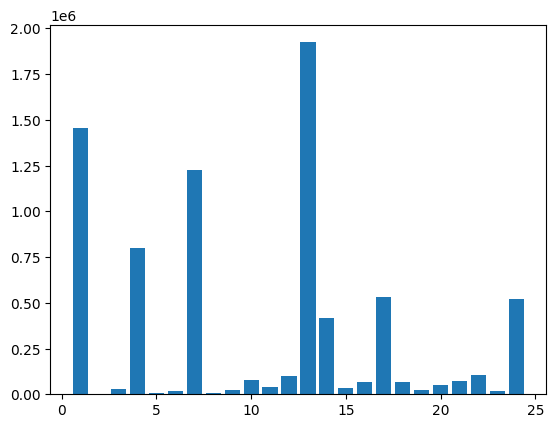

In [13]:
%%local
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.clf()
plt.bar(sqlDF.DOLocationID, sqlDF.sum_total_amount)
plt.show()

---
## 5. Visualize your data using Python 
#### Use matplotlib to plot the drop off location and the total amount as a bar chart

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.clf()
df = sqlDF.toPandas()
plt.bar(df.DOLocationID, df.sum_total_amount)
%matplot plt

In [12]:
%%spark -o df
df = sqlDF

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

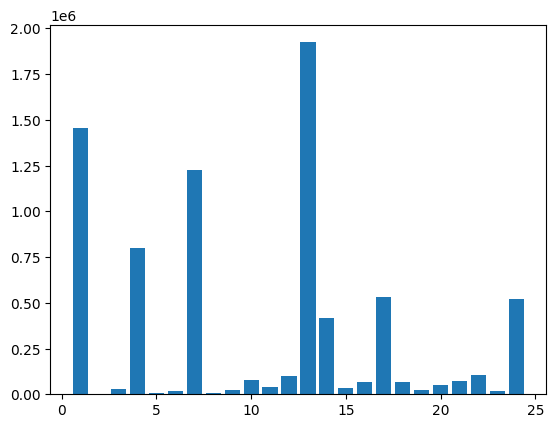

In [9]:
%%local
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.clf()
# df = sqlDF.toPandas()
plt.bar(df.DOLocationID, df.sum_total_amount)
plt.show()

### You have made it to the end of the demo notebook!!